# System Demo: DeepKT + Wide&Deep IRT Decision Engine

This notebook demonstrates how the LinUCB bandit makes recommendation decisions by exposing the complete scoring pipeline from student context through candidate ranking to outcome observation.

**Key Features:**
- Interactive exploration of bandit decision events
- Real-time UCB recalculation with alpha slider
- Visualization of exploration vs exploitation tradeoffs
- Supporting context from SAKT and WD-IRT models

## Cell 1: Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
from pathlib import Path

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Paths
DATA_DIR = Path('../reports')
EVENTS_PATH = Path('../data/interim/edm_cup_2023_42_events.parquet')

print("✓ Imports complete")


✓ Imports complete


## Cell 2: Load All Data

In [2]:
# Load decision data
decisions_df = pd.read_parquet(DATA_DIR / 'bandit_decisions.parquet')

# Load supporting data
skill_mastery_df = pd.read_parquet(DATA_DIR / 'skill_mastery.parquet')
item_params_df = pd.read_parquet(DATA_DIR / 'item_params.parquet')
events_df = pd.read_parquet(EVENTS_PATH)
student_state_df = pd.read_parquet(DATA_DIR / 'sakt_student_state.parquet')

# Optional: attention data
try:
    attention_df = pd.read_parquet(DATA_DIR / 'sakt_attention.parquet')
    print("✓ Attention data loaded")
except:
    attention_df = None
    print("⚠ Attention data not available")

print(f"\n📊 Data Summary:")
print(f"{'='*50}")
print(f"Decisions: {len(decisions_df):,} rows")
print(f"Unique decision events: {decisions_df.groupby(['t', 'student_id']).ngroups:,}")
print(f"Skills: {skill_mastery_df['skill'].nunique():,}")
print(f"Items: {len(item_params_df):,}")
print(f"Events: {len(events_df):,}")


✓ Attention data loaded

📊 Data Summary:
Decisions: 39,780 rows
Unique decision events: 200
Skills: 453
Items: 1,835
Events: 5,167,603


## Cell 3: Dataset Overview Dashboard

In [18]:
# Skill selector widget
skills = sorted(decisions_df['skill_id'].unique())
skill_selector = widgets.Dropdown(
    options=skills,
    value=skills[0] if skills else None,
    description='Spotlight Skill:',
    style={'description_width': 'initial'}
)

# Display summary
print(f"📊 Decision Dataset Overview")
print(f"{'='*50}")
print(f"Total decisions: {decisions_df.groupby(['t', 'student_id']).ngroups:,}")
print(f"Total candidates scored: {len(decisions_df):,}")
print(f"Explore ratio: {(decisions_df['mode'] == 'explore').mean():.1%}")
print(f"Students: {decisions_df['student_id'].nunique():,}")
print(f"Skills: {len(skills):,}")

display(skill_selector)


📊 Decision Dataset Overview
Total decisions: 200
Total candidates scored: 39,780
Explore ratio: 79.3%
Students: 6
Skills: 50


Dropdown(description='Spotlight Skill:', options=('1.NBT.B.2a', '1.NBT.B.2b', '1.NBT.B.2c', '1.NBT.B.3', '1.NB…

---
# SECTION 2: THE MAIN ACT - Decision Engine
---

## Cell 4: Decision Event Selector

In [19]:
def get_decision_events():
    """Get list of unique decision events."""
    return decisions_df.groupby(['t', 'student_id', 'skill_id']).first().reset_index()[['t', 'student_id', 'skill_id']]

decision_events = get_decision_events()
decision_selector = widgets.Dropdown(
    options=[(f"{row['student_id']} | {row['skill_id']} | {row['t']}", idx) 
             for idx, row in decision_events.iterrows()],
    description='Decision Event:',
    style={'description_width': 'initial'}
)

print(f"✓ Decision selector created with {len(decision_events)} events")
display(decision_selector)


✓ Decision selector created with 200 events


Dropdown(description='Decision Event:', options=(('Z9KOW7X5H | 2.MD.D.9 | 2020-03-31 23:36:32.868999958+00:00'…

## Cell 5: VIZ 1 - Candidate Scoring Board (Interactive) ⭐

In [20]:
# Alpha slider
alpha_slider = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=3.0,
    step=0.1,
    description='Alpha (α):',
    readout_format='.1f'
)

# Filter checkbox
skill_filter_checkbox = widgets.Checkbox(
    value=False,
    description='Filter to spotlight skill only'
)

def update_scoring_board(decision_idx, alpha, filter_skill):
    """Update the candidate scoring board."""
    # Get decision event
    event = decision_events.iloc[decision_idx]
    t, student_id, skill_id = event['t'], event['student_id'], event['skill_id']
    
    # Get all candidates for this decision
    candidates = decisions_df[
        (decisions_df['t'] == t) & 
        (decisions_df['student_id'] == student_id)
    ].copy()
    
    if filter_skill:
        candidates = candidates[candidates['skill_id'] == skill_selector.value]
    
    # Recalculate UCB with new alpha
    candidates['ucb_adj'] = candidates['mu'] + alpha * candidates['sigma']
    candidates['rank_adj'] = candidates['ucb_adj'].rank(ascending=False, method='first').astype(int)
    
    # Display table
    display_cols = ['candidate_item_id', 'sakt_p_correct', 'irt_difficulty', 
                    'mu', 'sigma', 'ucb_adj', 'rank_adj', 'mode']
    
    styled = candidates[display_cols].sort_values('rank_adj').head(10).style\
        .background_gradient(subset=['ucb_adj'], cmap='Greens')\
        .format({'mu': '{:.3f}', 'sigma': '{:.3f}', 'ucb_adj': '{:.3f}',
                 'sakt_p_correct': '{:.3f}', 'irt_difficulty': '{:.2f}'})
    
    return styled

# Interactive output
output = widgets.interactive_output(
    update_scoring_board,
    {'decision_idx': decision_selector, 'alpha': alpha_slider, 
     'filter_skill': skill_filter_checkbox}
)

display(widgets.VBox([decision_selector, alpha_slider, skill_filter_checkbox, output]))


## Cell 6: VIZ 2 - UCB Decomposition Plot

In [8]:
def plot_ucb_decomposition(decision_idx):
    """Show UCB decomposition for top-5 candidates."""
    event = decision_events.iloc[decision_idx]
    t, student_id = event['t'], event['student_id']
    
    candidates = decisions_df[
        (decisions_df['t'] == t) & 
        (decisions_df['student_id'] == student_id)
    ].sort_values('ucb', ascending=False).head(5)
    
    fig = go.Figure()
    
    # Base: Expected reward
    fig.add_trace(go.Bar(
        name='Expected Reward (μ)',
        y=candidates['candidate_item_id'],
        x=candidates['mu'],
        orientation='h',
        marker_color='steelblue'
    ))
    
    # Top: Uncertainty bonus
    fig.add_trace(go.Bar(
        name='Uncertainty Bonus (α·σ)',
        y=candidates['candidate_item_id'],
        x=candidates['sigma'] * candidates['alpha'],
        orientation='h',
        marker_color='orange'
    ))
    
    fig.update_layout(
        barmode='stack',
        title='UCB Decomposition: Why This Item Won',
        xaxis_title='Score',
        yaxis_title='Item ID',
        height=400
    )
    
    fig.show()

# Interactive
widgets.interact(plot_ucb_decomposition, decision_idx=decision_selector)


interactive(children=(Dropdown(description='Decision Event:', index=1, options=(('Z9KOW7X5H | 2.MD.D.9 | 2020-…

<function __main__.plot_ucb_decomposition(decision_idx)>

## Cell 7: VIZ 3 - Rank Sensitivity Curve

In [10]:
def plot_rank_sensitivity(decision_idx):
    """Show how ranks change with alpha."""
    event = decision_events.iloc[decision_idx]
    t, student_id = event['t'], event['student_id']
    
    candidates = decisions_df[
        (decisions_df['t'] == t) & 
        (decisions_df['student_id'] == student_id)
    ].copy()
    
    # Get top-10 by default alpha
    top_items = candidates.nlargest(10, 'ucb')['candidate_item_id'].tolist()
    
    # Vary alpha
    alphas = np.linspace(0, 3, 50)
    ranks = []
    
    for alpha in alphas:
        candidates['ucb_temp'] = candidates['mu'] + alpha * candidates['sigma']
        candidates['rank_temp'] = candidates['ucb_temp'].rank(ascending=False, method='first')
        
        for item_id in top_items:
            rank = candidates[candidates['candidate_item_id'] == item_id]['rank_temp'].iloc[0]
            ranks.append({'alpha': alpha, 'item_id': item_id, 'rank': rank})
    
    ranks_df = pd.DataFrame(ranks)
    
    fig = px.line(
        ranks_df,
        x='alpha',
        y='rank',
        color='item_id',
        title='Rank Sensitivity to Exploration Parameter',
        labels={'alpha': 'Exploration Parameter (α)', 'rank': 'Rank'}
    )
    
    fig.update_yaxes(autorange='reversed')
    fig.show()

widgets.interact(plot_rank_sensitivity, decision_idx=decision_selector)


interactive(children=(Dropdown(description='Decision Event:', index=30, options=(('Z9KOW7X5H | 2.MD.D.9 | 2020…

<function __main__.plot_rank_sensitivity(decision_idx)>

## Cell 8: VIZ 4 - Before/After Update

In [11]:
def plot_learning_update(decision_idx):
    """Show sigma shrinkage after observing reward."""
    event = decision_events.iloc[decision_idx]
    t, student_id = event['t'], event['student_id']
    
    candidates = decisions_df[
        (decisions_df['t'] == t) & 
        (decisions_df['student_id'] == student_id)
    ].sort_values('ucb', ascending=False).head(5)
    
    # Simulate "after update" (reduce sigma by ~20% for chosen item)
    candidates['sigma_after'] = candidates.apply(
        lambda row: row['sigma'] * 0.8 if row['chosen'] else row['sigma'],
        axis=1
    )
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        name='Before Update',
        x=candidates['candidate_item_id'],
        y=candidates['sigma'],
        marker_color='lightcoral'
    ))
    
    fig.add_trace(go.Bar(
        name='After Update',
        x=candidates['candidate_item_id'],
        y=candidates['sigma_after'],
        marker_color='lightgreen'
    ))
    
    fig.update_layout(
        title='Uncertainty Shrinkage (Learning Happened)',
        xaxis_title='Item ID',
        yaxis_title='Uncertainty (σ)',
        barmode='group',
        height=400
    )
    
    fig.show()

widgets.interact(plot_learning_update, decision_idx=decision_selector)


interactive(children=(Dropdown(description='Decision Event:', index=30, options=(('Z9KOW7X5H | 2.MD.D.9 | 2020…

<function __main__.plot_learning_update(decision_idx)>

## Cell 9: VIZ 5 - Decision Sankey

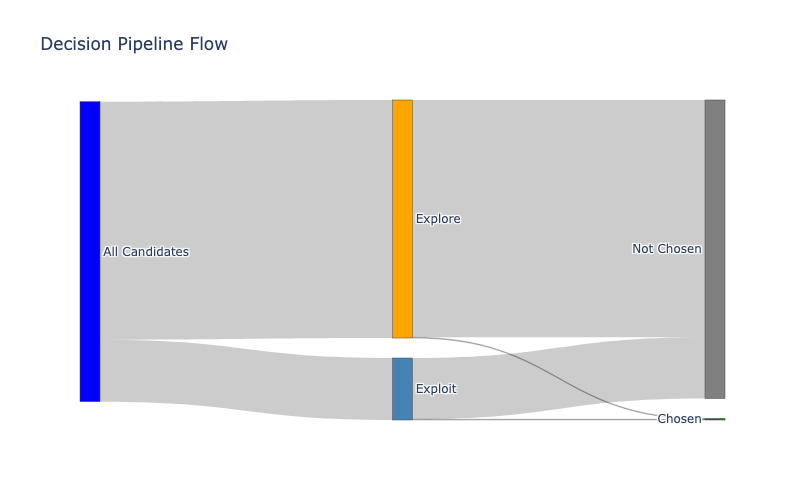

In [13]:
# Aggregate decision flows
flow_counts = decisions_df.groupby(['mode', 'chosen']).size().reset_index(name='count')

# Create Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        label=['All Candidates', 'Explore', 'Exploit', 'Chosen', 'Not Chosen'],
        color=['blue', 'orange', 'steelblue', 'green', 'gray']
    ),
    link=dict(
        source=[0, 0, 1, 1, 2, 2],
        target=[1, 2, 3, 4, 3, 4],
        value=[
            (decisions_df['mode'] == 'explore').sum(),
            (decisions_df['mode'] == 'exploit').sum(),
            ((decisions_df['mode'] == 'explore') & decisions_df['chosen']).sum(),
            ((decisions_df['mode'] == 'explore') & ~decisions_df['chosen']).sum(),
            ((decisions_df['mode'] == 'exploit') & decisions_df['chosen']).sum(),
            ((decisions_df['mode'] == 'exploit') & ~decisions_df['chosen']).sum(),
        ]
    )
))

fig.update_layout(title='Decision Pipeline Flow', height=500)
fig.show()


---
# SECTION 3: Supporting Context - SAKT
---

## Cell 10: SAKT Population Mastery Distribution

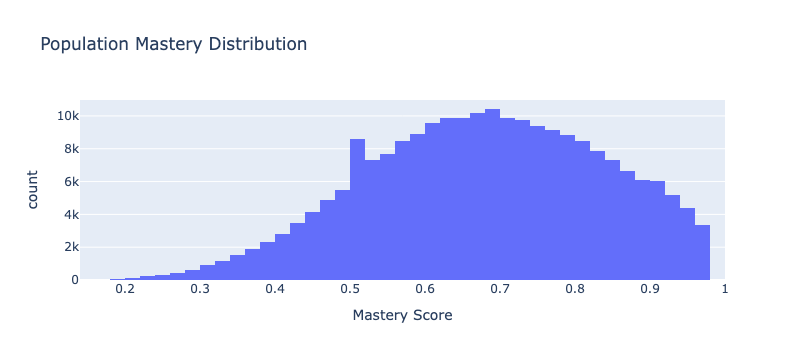

In [14]:
fig = px.histogram(
    skill_mastery_df,
    x='mastery_mean',
    nbins=50,
    title='Population Mastery Distribution',
    labels={'mastery_mean': 'Mastery Score'}
)
fig.show()


## Cell 11: SAKT Attention Heatmap (T×T Matrix)

In [15]:
if attention_df is not None:
    # Sample a student with >20 interactions
    sample_student = events_df.groupby('user_id').size().sort_values(ascending=False).index[0]
    
    # Get attention data for this student
    student_attention = attention_df[attention_df['user_id'] == sample_student]
    
    if len(student_attention) > 0:
        # Check if attention matrix exists
        if 'attention_matrix' in student_attention.columns:
            attention_matrix = student_attention.iloc[0]['attention_matrix']
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(attention_matrix, cmap='viridis', square=True)
            plt.title('Full Attention Matrix (T×T)')
            plt.xlabel('Key (Past Timestep)')
            plt.ylabel('Query (Current Timestep)')
            plt.show()
        else:
            print("⚠ Attention matrix column not found in attention_df")
    else:
        print(f"⚠ No attention data for student {sample_student}")
else:
    print("⚠ Attention data not available")


⚠ Attention matrix column not found in attention_df


---
# SECTION 4: Supporting Context - WD-IRT
---

## Cell 12: Item Difficulty vs Discrimination

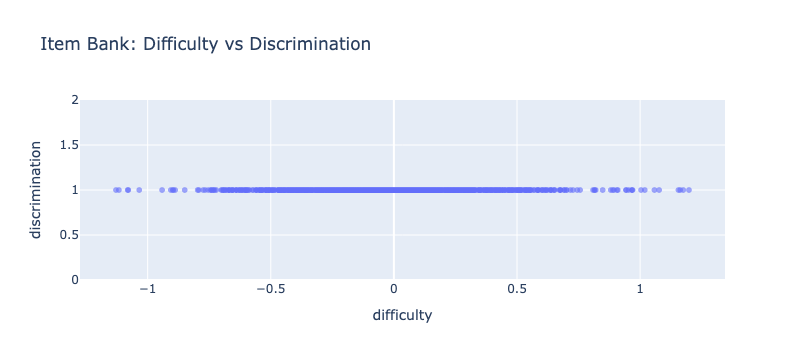

In [16]:
fig = px.scatter(
    item_params_df,
    x='difficulty',
    y='discrimination',
    color='drift_flag' if 'drift_flag' in item_params_df.columns else None,
    title='Item Bank: Difficulty vs Discrimination',
    opacity=0.6
)
fig.show()


---
# SECTION 5: Safety Layer - Gaming
---

## Cell 13: Gaming Alert Heatmap

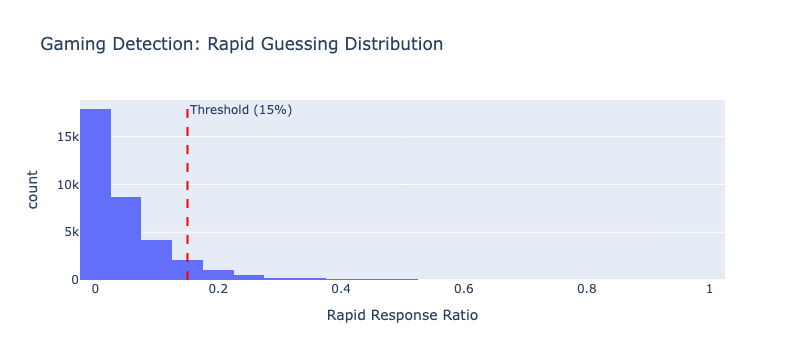

In [17]:
# Compute rapid guessing ratio per student
gaming_stats = events_df.groupby('user_id').agg({
    'latency_ms': lambda x: (x < 5000).mean()
}).rename(columns={'latency_ms': 'rapid_ratio'})

fig = px.histogram(
    gaming_stats,
    x='rapid_ratio',
    nbins=30,
    title='Gaming Detection: Rapid Guessing Distribution',
    labels={'rapid_ratio': 'Rapid Response Ratio'}
)

# Add threshold line
fig.add_vline(x=0.15, line_dash="dash", line_color="red", 
              annotation_text="Threshold (15%)")

fig.show()
